In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
datasets, metadata = tfds.load('cycle_gan/horse2zebra', with_info=True, as_supervised=True)

tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)


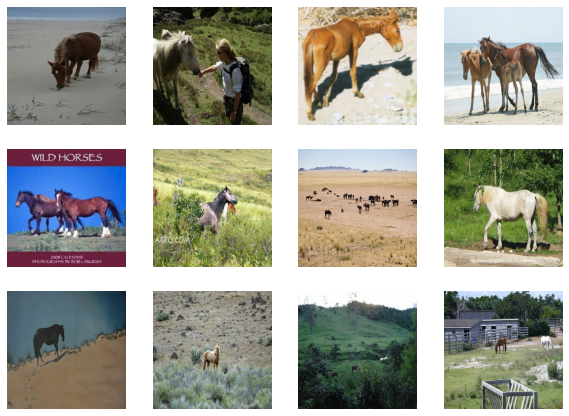

In [3]:
plt.figure(figsize=(10, 10))
for idx, (imgA, labelA) in zip(range(12), datasets['trainA']):
    imgA = tf.cast(imgA, tf.float32)
    imgA = imgA / 256
    plt.subplot(4, 4, idx+1)
    plt.axis(False)
    plt.imshow(imgA)
    print(labelA)

(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)
(1, 256, 256, 3)


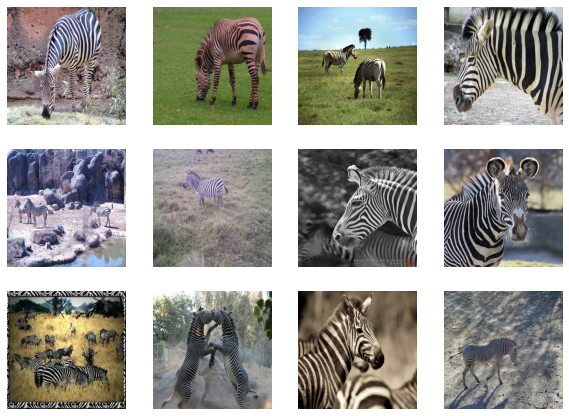

In [4]:
plt.figure(figsize=(10, 10))
for idx, (imgA, labelA) in zip(range(12), datasets['trainB'].batch(1)):
    imgA = tf.cast(imgA, tf.float32)
    imgA = imgA / 256
    plt.subplot(4, 4, idx+1)
    plt.axis(False)
    plt.imshow(imgA[0])
    print(imgA.shape)

In [5]:
sample_img = next(iter(datasets['trainA']))[0]
sample_img = tf.expand_dims(sample_img, axis=0)
print(sample_img.shape)

(1, 256, 256, 3)


In [95]:
def normalization(img):
    img = tf.cast(img, tf.float32)
    return img / 256.

def random_scale(img):
    scaled_img = tf.image.resize(img, [286, 286])
    scaled_img = tf.image.random_crop(img, tf.shape(img))
    return scaled_img

def random_flip(img):
    if tf.random.uniform([1]) > 0.5:
        img = tf.image.flip_left_right(img)
    return img

def preprocess(img, label=0):
    img = normalization(img)
    img = random_scale(img)
    img = random_flip(img)
    
    return img

print(sample_img.shape)
# plt.imshow(preprocess(sample_img)[0])

(1, 256, 256, 3)


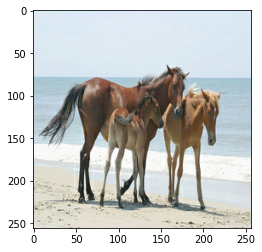

In [96]:
for idx, (img, label) in zip(range(4), datasets['trainA']):
    plt.imshow(preprocess(img))

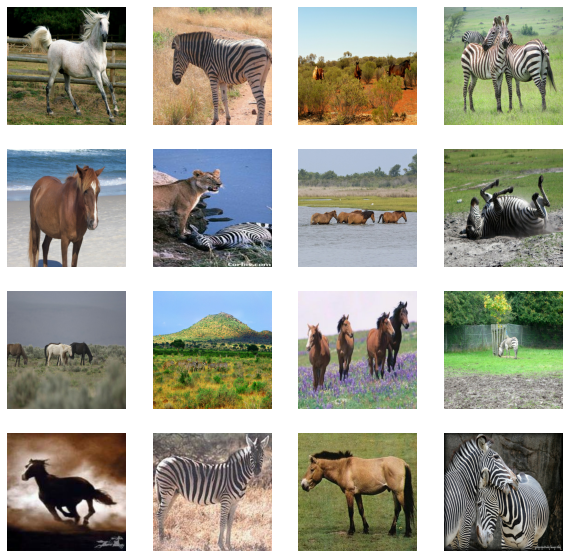

In [200]:
ds_train_horses = datasets['trainA'].shuffle(1000).batch(1).map(preprocess)
ds_train_zebra = datasets['trainB'].shuffle(1000).batch(1).map(preprocess)
ds_test_horses = datasets['testA'].shuffle(1000).batch(1).map(preprocess)
ds_test_zebra = datasets['testB'].shuffle(1000).batch(1).map(preprocess)

NUMBER_OF_SAMPLES = 4

plt.figure(figsize=(10,10))

idx = 1
for train_horse, train_zebra,test_horse,test_zebra in tf.data.Dataset.zip( (ds_train_horses, ds_train_zebra, ds_test_horses, ds_test_zebra)).take(NUMBER_OF_SAMPLES):
    plt.subplot(NUMBER_OF_SAMPLES, 4, idx)
    idx = idx+1
    plt.imshow(train_horse[0])
    plt.axis(False)
    plt.subplot(NUMBER_OF_SAMPLES, 4, idx)
    idx = idx+1
    plt.imshow(train_zebra[0])
    plt.axis(False)
    plt.subplot(NUMBER_OF_SAMPLES, 4, idx)
    idx = idx+1
    plt.imshow(test_horse[0])
    plt.axis(False)
    plt.subplot(NUMBER_OF_SAMPLES, 4, idx)
    idx = idx+1
    plt.imshow(test_zebra[0])
    plt.axis(False)
    

In [132]:
OUTPUT_CHANNELS = 3
generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type="instancenorm")
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type="instancenorm")

discriminator_x = pix2pix.discriminator(norm_type="instancenorm", target=False)
discriminator_y = pix2pix.discriminator(norm_type="instancenorm", target=False)


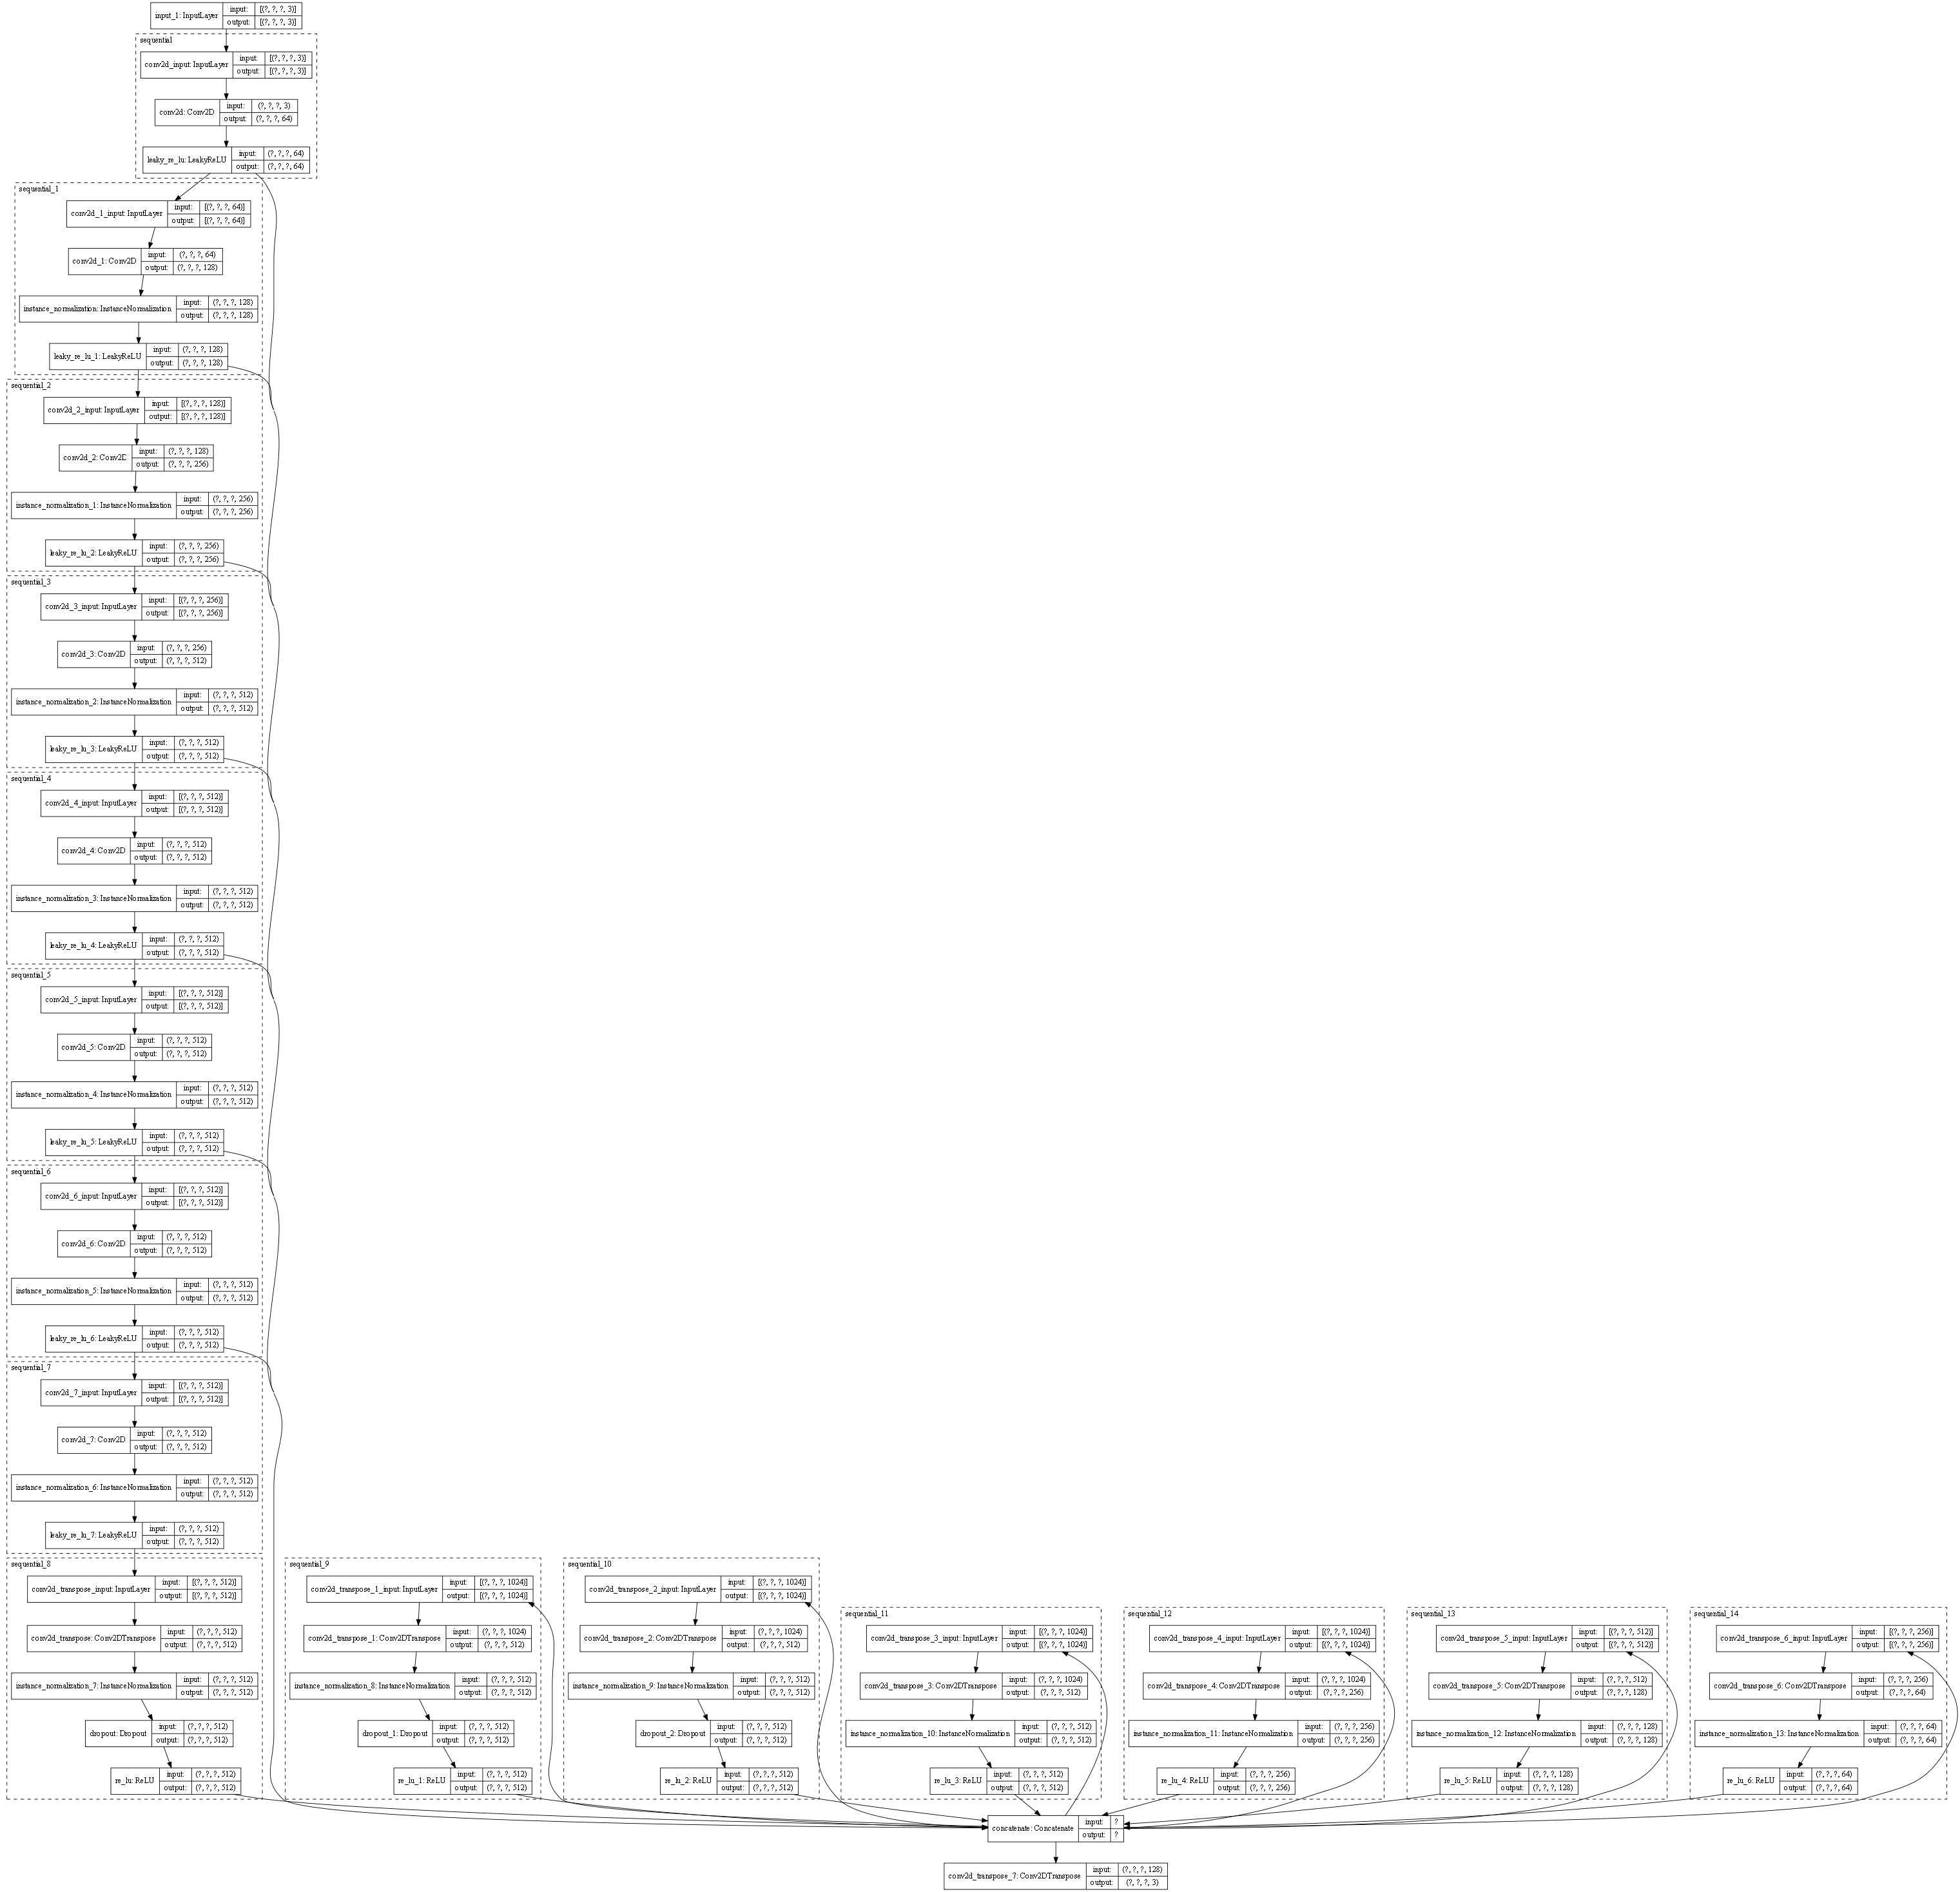

In [136]:
tf.keras.utils.plot_model(generator_g, dpi=64, show_shapes=True, expand_nested=True)

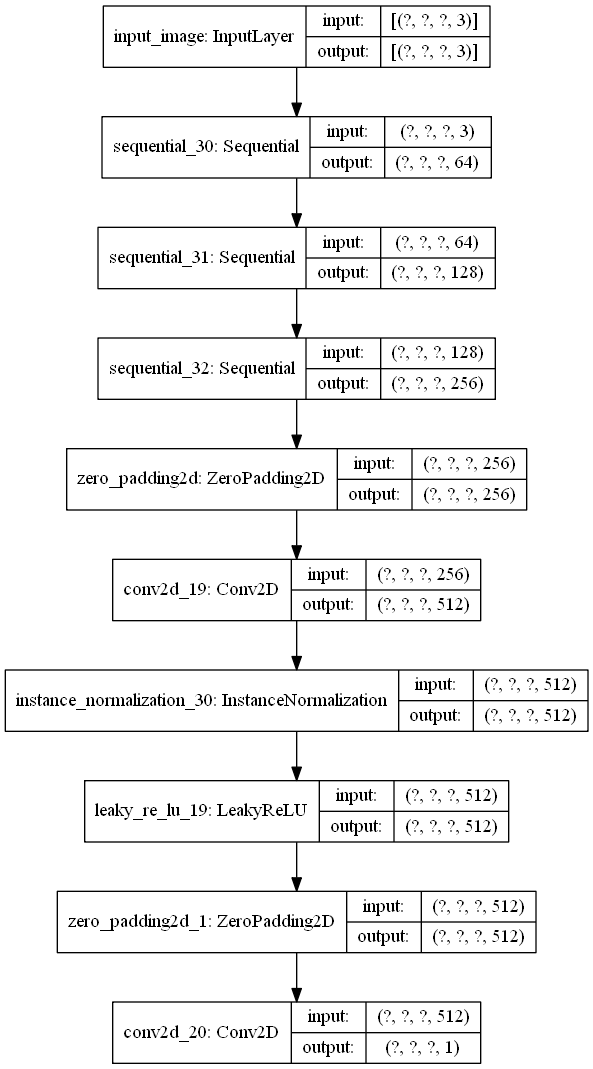

In [137]:
tf.keras.utils.plot_model(discriminator_x, show_shapes=True, dpi=96)

(1, 256, 256, 3)


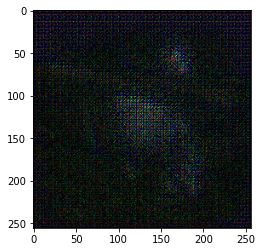

In [185]:
test_sample_horse = next(iter(ds_test_horses))
print(generator_g(test_sample_horse).shape)
plt.imshow(generator_g(test_sample_horse)[0])

In [196]:
LAMBDA = 10
loss_obj = tf.losses.BinaryCrossentropy(from_logits=True)

def generator_loss_identity(real_x, same_x):
    return tf.reduce_mean(tf.abs(real_x - same_x)) * LAMBDA * 0.5

def generator_loss_cyclic(real_x, cycle_x):
    return tf.reduce_mean(tf.abs(real_x - cycle_x)) * LAMBDA

def generator_loss(disc_from_generated):
    target = tf.ones_like(disc_from_generated)
    return loss_obj(target, disc_from_generated)

def discriminator_loss(real, fake):
    target_real = tf.ones_like(real)
    target_fake = tf.zeros_like(fake)
    loss_real = loss_obj(target_real, real)
    loss_fake = loss_obj(target_fake, fake)
    return (loss_real + loss_fake) * 0.5

In [163]:
disc_1 = discriminator_x(generator_g(test_sample_horse))
disc_2 = discriminator_x(test_sample_horse)
print("gen loss:", generator_loss(disc_1))
print("disc loss:", discriminator_loss(disc_1, disc_1))


gen loss: tf.Tensor(0.7008455, shape=(), dtype=float32)
disc loss: tf.Tensor(0.8812441, shape=(), dtype=float32)


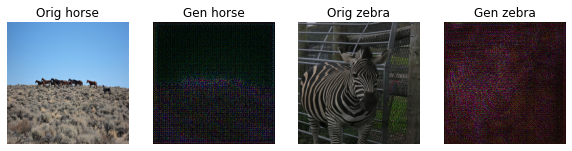

In [189]:
def print_temp_images(generator_g, generator_f, img_horse, img_zebra):
    generated_horse = generator_g(img_horse)
    generated_zebra = generator_f(img_zebra)
    
    plt.figure(figsize=(10,10))
    plt.subplot(1, 4, 1)
    plt.imshow(img_horse[0])
    plt.axis(False)
    plt.title("Orig horse")

    plt.subplot(1, 4, 2)
    plt.imshow(generated_horse[0])
    plt.axis(False)
    plt.title("Gen horse")

    plt.subplot(1, 4, 3)
    plt.imshow(img_zebra[0])
    plt.axis(False)
    plt.title("Orig zebra")

    plt.subplot(1, 4, 4)
    plt.imshow(generated_zebra[0])
    plt.axis(False)
    plt.title("Gen zebra")

print_temp_images(generator_g, generator_f, test_horse, test_zebra)
    

In [ ]:
import datetime

log_dir = "logs/"
summary_writer = tf.summary.create_file_writer(log_dir + "CycleGAN/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

%load_ext tensorboard
%tensorboard --logdir logs

In [202]:
generator_g_optimizer = tf.optimizers.Adam()
generator_f_optimizer = tf.optimizers.Adam()
discriminator_x_optimizer = tf.optimizers.Adam()
discriminator_y_optimizer = tf.optimizers.Adam()

In [208]:
checkpoint_path = os.path.join("checkpoints", "cycle_gan")
chkpt = tf.train.Checkpoint(generator_f=generator_f,
                            generator_g=generator_g,
                            disriminator_x=discriminator_x,
                            disriminator_y=discriminator_y,
                            generator_g_optimizer = generator_g_optimizer,
                            generator_f_optimizer = generator_f_optimizer,
                            discriminator_x_optimizer = discriminator_x_optimizer,
                            discriminator_y_optimizer = discriminator_y_optimizer
                           )

chkpt_manager = tf.train.CheckpointManager(chkpt, checkpoint_path, max_to_keep=5)

if(chkpt_manager.latest_checkpoint):
    chkpt.restore(chkpt_manager.latest_checkpoint)

EPOCH  0
...........................................................................................................
checkpointed to  checkpoints/train\ckpt-1
epoch time: 6.209514856338501


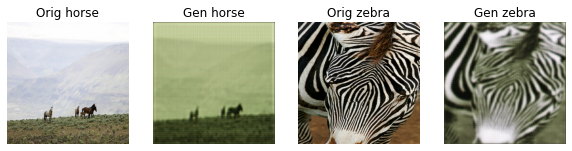

EPOCH  1
...........................................................................................................
epoch time: 2.3380260467529297
EPOCH  2
...........................................................................................................
epoch time: 2.4670217037200928
EPOCH  3
...........................................................................................................
epoch time: 2.4509902000427246
EPOCH  4
...........................................................................................................
epoch time: 2.489056348800659
EPOCH  5
...........................................................................................................
checkpointed to  checkpoints/train\ckpt-2
epoch time: 4.996089696884155
EPOCH  6
...........................................................................................................
epoch time: 2.396017074584961
EPOCH  7
................................................................

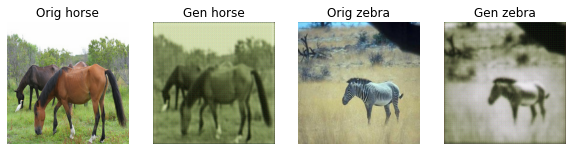

EPOCH  11
...........................................................................................................
epoch time: 2.7620251178741455
EPOCH  12
...........................................................................................................
epoch time: 2.786029100418091
EPOCH  13
...........................................................................................................
epoch time: 2.7700300216674805
EPOCH  14
...........................................................................................................
epoch time: 2.805025577545166
EPOCH  15
...........................................................................................................
checkpointed to  checkpoints/train\ckpt-4
epoch time: 8.090333223342896
EPOCH  16
...........................................................................................................
epoch time: 2.424025535583496
EPOCH  17
..........................................................

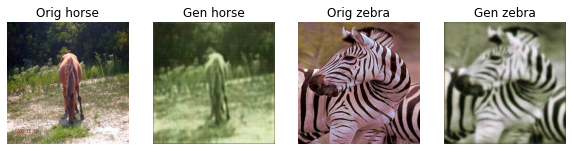

EPOCH  21
...........................................................................................................
epoch time: 2.8376662731170654
EPOCH  22
...........................................................................................................
epoch time: 2.9850308895111084
EPOCH  23
...........................................................................................................
epoch time: 2.893082618713379
EPOCH  24
...........................................................................................................
epoch time: 3.0410332679748535
EPOCH  25
...........................................................................................................
checkpointed to  checkpoints/train\ckpt-6
epoch time: 8.615188598632812
EPOCH  26
...........................................................................................................
epoch time: 2.8209221363067627
EPOCH  27
........................................................

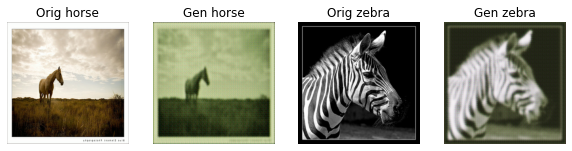

EPOCH  31
...........................................................................................................
epoch time: 3.106335163116455
EPOCH  32
...........................................................................................................
epoch time: 3.0939066410064697
EPOCH  33
...........................................................................................................
epoch time: 2.9799981117248535
EPOCH  34
...........................................................................................................
epoch time: 3.1920318603515625
EPOCH  35
...........................................................................................................
checkpointed to  checkpoints/train\ckpt-8
epoch time: 7.382592439651489
EPOCH  36
...........................................................................................................
epoch time: 3.013023614883423
EPOCH  37
.........................................................

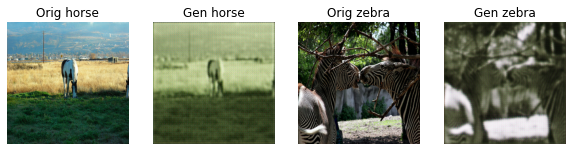

EPOCH  41
...........................................................................................................
epoch time: 3.0839998722076416
EPOCH  42
...........................................................................................................
epoch time: 3.1170356273651123
EPOCH  43
...........................................................................................................
epoch time: 2.969024181365967
EPOCH  44
...........................................................................................................
epoch time: 2.985121488571167
EPOCH  45
...........................................................................................................
checkpointed to  checkpoints/train\ckpt-10
epoch time: 5.943047523498535
EPOCH  46
...........................................................................................................
epoch time: 3.0360329151153564
EPOCH  47
........................................................

In [205]:
@tf.function
def make_step(real_x, real_y, epoch):
    with tf.GradientTape(persistent = True) as tape:
        fake_y  = generator_g(real_x, training=True)
        cycle_x = generator_f(fake_y, training=True)

        fake_x  = generator_f(real_y, training=True)
        cycle_y = generator_g(fake_x, training=True)
        
        same_x  = generator_f(real_x, training=True)
        same_y  = generator_g(real_y, training=True)
        
        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)

        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        _generator_loss_cyclic = generator_loss_cyclic(real_x, cycle_x) + generator_loss_cyclic(real_y, cycle_y)
        
        generator_g_loss_total = generator_loss(disc_fake_y) + _generator_loss_cyclic + generator_loss_identity(real_y, same_y)
        generator_f_loss_total = generator_loss(disc_fake_x) + _generator_loss_cyclic + generator_loss_identity(real_x, same_x)
        
        discriminator_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        discriminator_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
        
    generator_g_gradients = tape.gradient(generator_g_loss_total, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(generator_f_loss_total, generator_f.trainable_variables)

    discriminator_x_gradients = tape.gradient(discriminator_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(discriminator_y_loss, discriminator_y.trainable_variables)
    
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))

    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

    with summary_writer.as_default():
        tf.summary.scalar("gen_g_loss_total", generator_g_loss_total, step=epoch)
        tf.summary.scalar("gen_f_loss_total", generator_f_loss_total, step=epoch)
        tf.summary.scalar("generator_loss_cyclic", _generator_loss_cyclic, step=epoch)
        tf.summary.scalar("generator_loss_identity_x", generator_loss_identity(real_x, same_x), step=epoch)
        tf.summary.scalar("generator_loss_identity_y", generator_loss_identity(real_y, same_y), step=epoch)
        tf.summary.scalar("disc_loss_x",      discriminator_x_loss, step=epoch)
        tf.summary.scalar("disc_loss_y",      discriminator_y_loss, step=epoch)


EPOCHS = 50
for epoch in range(EPOCHS):
    print("EPOCH ", epoch)
    start = time.time()
    for idx, (img_horse, img_zebra) in enumerate(tf.data.Dataset.zip((ds_train_horses, ds_train_zebra))):
        if(idx % 10 == 0):
            print(".", end="")
#         make_step(img_horse, img_zebra, epoch)
    print()

    if(epoch % 5 == 0):
        chkpt_path = chkpt_manager.save()
        print("checkpointed to ", chkpt_path)
    print("epoch time:", time.time() - start)
    if(epoch % 10 == 0):
      print_temp_images(generator_g, generator_f, img_horse, img_zebra)
    plt.show()
    
